In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.utils import *
from aeons.endpoint import *
from aeons.regress import *
from aeons.likelihoods import full
from aeons.plotting import *
# Set default matplotlib figure size to (4,2)
plt.rcParams['figure.figsize'] = (4,2)

In [2]:
chain, samples = get_samples("toy", "gauss_30_01")

(-40.0, 0.0)

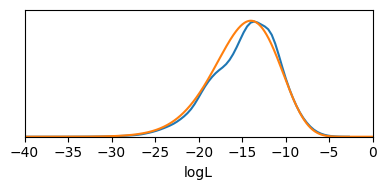

In [13]:
samples.plot_1d("logL")
def PlogL(logL, d):
    from scipy.special import gamma
    return 1/gamma(d/2) * np.exp(logL) * (-logL)**(d/2 - 1)
plt.plot(samples.logL, PlogL(samples.logL, d=30) * 9.5, label="d=30")
plt.xlim(-40, 0)

In [16]:
# Implement prior cutoff
def cutoff_prior(logL, X, epsilon=1e-3):
    """
    Cut off L(X) for X < epsilon = 1e-3, since the samples above this compression are shaped like the prior
    """
    if X[0] < epsilon:
        return logL, X
    else:    
        posterior_samples = X < epsilon
        logL = logL[posterior_samples]
        X = X[posterior_samples]
        return logL, X

In [156]:
chain, samples = get_samples("toy", "wedding_20_001")
model = EndModel(samples)
true_endpoint = model.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

In [199]:
ndead = 20000
logL, X_mean, nk, logZdead = model.data(ndead)
logLd, Xd = cutoff_prior(logL, X_mean)
N_prior = len(X_mean) - len(Xd)
N_prior

2491

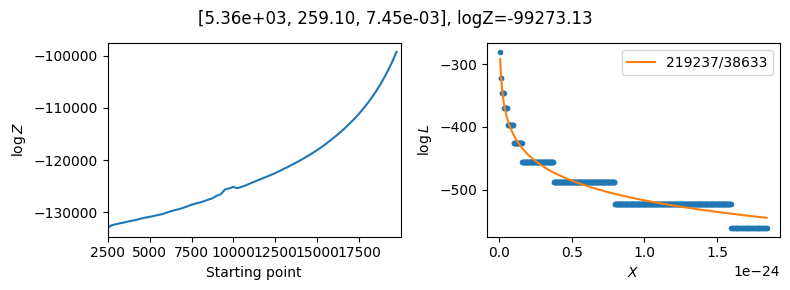

In [200]:
# Calculate logZ for different starting points
starts = np.arange(N_prior, ndead, 250)
logZs = np.zeros(len(starts))
logXfs = np.zeros(len(starts))
for i, start in enumerate(starts):
    window = np.arange(start, len(logL))
    logLd, Xd = logL[window], X_mean[window]
    reg = GaussianRegress(logLd, Xd)
    logZs[i] = reg.logZ() - (start - N_prior) * np.log(logLd.max() - logLd.min())
    logXfs[i] = logXf_formula(reg.theta, logZdead, X_mean[ndead])
    
# Set logZs to -inf for starting points that make logXf NaN
logZs[np.isnan(logXfs)] = -np.inf
# Find prediction for best starting point
start_best = starts[np.argmax(logZs)]
window_best = np.arange(start_best, len(logL))
logLd, Xd = logL[window_best], X_mean[window_best]
reg = GaussianRegress(logLd, Xd)
logXf = logXf_formula(reg.theta, logZdead, X_mean[ndead])
endpoint = calc_endpoints([ndead], np.log(X_mean[ndead]), logXf, 0, nlive=375)[0]

# Plot logZ vs. starting point and theta
fig, axs = plt.subplots(1, 2, figsize=(8,3))
# Plot logZ vs. starting point, skipping infinities
axs[0].plot(starts[logZs > -np.inf], logZs[logZs > -np.inf])
axs[0].set_xlim(starts[0], starts[-1])
axs[0].set_xlabel("Starting point")
axs[0].set_ylabel(r"$\log Z$")
axs[1].plot(Xd, logLd, ".")
axs[1].plot(Xd, full.func(Xd, reg.theta), "-", label=f"{endpoint[0]:.0f}/{true_endpoint:.0f}")
axs[1].set_xlabel(r"$X$")
axs[1].set_ylabel(r"$\log L$")
axs[1].legend()
fig.suptitle(f"{formatt(reg.theta)}, logZ={logZs.max():.2f}", y=0.95)
fig.tight_layout()

In [158]:
# Plot logL vs X for different starting points using @interact
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

starts = widgets.IntSlider(min=N_prior, max=len(logL)-1, step=100)
@interact(start=starts)
def plot_logL(start):
    window = np.arange(start, len(logL))
    plt.plot(X_mean[window], logL[window], label="logL")

interactive(children=(IntSlider(value=2491, description='start', max=20280, min=2491, step=100), Output()), _d…

In [173]:
true_endpoint

38633

In [132]:
start_best = starts[np.argmax(logZs)]
window_best = np.arange(start_best, len(logL))
logLd, Xd = logL[window_best], X_mean[window_best]
reg = GaussianRegress(logLd, Xd)
logXf = logXf_formula(reg.theta, logZdead, X_mean[ndead])
endpoint = calc_endpoints([ndead], np.log(X_mean[ndead]), logXf, 0, nlive=1000)[0]
print(f"True endpoint: {true_endpoint}, Estimated endpoint: {endpoint}")

True endpoint: 57372, Estimated endpoint: [53231.87433742]
